# 20 NewsGroup NLP Classification

To generate a ML text classification algorithm, we are using the famous **20Newsgroup dataset**, collected by Ken Lang, containing 20 different classes and about 20'000 text documents. 

The dataset contains two attributes:

*   data;
*   target;

The data is organized into 20 different newsgroups, with each text corresponding to a different topic or label:

•	alt.atheism

•	comp.graphics

•	comp.os.ms-windows.misc

•	comp.sys.ibm.pc.hardware

•	comp.sys.mac.hardware

•	comp.windows.x

•	misc.forsale

•	rec.autos

•	rec.motorcycles

•	rec.sport.baseball

•	rec.sport.hockey

•	sci.crypt

•	sci.electronics

•	sci.med

•	sci.space

•	soc.religion.christian

•	talk.politics.guns

•	talk.politics.mideast

•	talk.politics.misc

•	talk.religion.misc

Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). 
Of course, we are dealing with a multiclass classification, that involves the task of classifying input instances into one of multiple classes. 

In [1]:
import pandas as pd 
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys


import nltk
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler ,LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
import itertools

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics

from keras.models import load_model
import joblib

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cbar = plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #cbar.remove()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if str.lower(str.strip(token.lemma_)) not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)


vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)
prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

def word_freq(label): return pd.Series([ t for t in nlp(grouped_vocabolary[label])] ).value_counts()

def make_custom_predictions(fitted_pipe):
    prep_text = pipe_spacy_preprocessing.transform( pd.Series(input('Input-Text:')))
    predictions_proba = pd.Series( keras_model_emb.model.predict( emb_class.transform(prep_text) )[0] , index= label_names)

    ranked_predictions  = predictions_proba.sort_values(ascending=True)

    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    chart = ax.barh(ranked_predictions.index ,ranked_predictions )
    plt.title('Predictions')
    return chart , ranked_predictions

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def save_keras_pipe(pipeline,name_model = 'keras_model.h5', name_pipe ='sklearn_pipeline.pkl' ):
    # Save the Keras model first:
    pipeline.named_steps['kc'].model.save(name_model)

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kc'].model = None

    # Finally, save the pipeline:
    joblib.dump(pipeline, name_pipe)

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davide_lupis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First of all, we imported the dataset by removing headers, footers, quotes.
The original attributes were remoduled according to the following division:  

• **text**: containing document corpus

• **label**: contain text's topic

• **target**: an integer assigned to each different topic. 

Then, for an easier to comprehend classification, we grouped the newgroups in eight macro categories:

•	Politics

•	Sport

•	Religion 

•	Computer 

•	Sales

•	Automobile

•	Science 

•	Medicine 

In [2]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)
#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Encode categorical variables in integer levels 
label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])
#SHuffle
df = df.sample(frac = 1)
# DROPNAN
df = df.dropna()
# dependent and independent variable
X = df['text']
y = df['target']
#_____________________________________________________________________________________________________________________________________________
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [3]:
print(df.shape)
df.head()

(10834, 3)


,text,label,target
9474,\nJeff Fenholt claims to have once been a road...,religion,4
10971,\n\n\nI suspect you mean laparoscopic instead ...,medicine,2
6683,\nObviously some reporter for the Ottawa Sun g...,sport,7
5540,Does anyone have a radon transform in C that t...,computer,1
9523,"If the set is direct line powered, try checkin...",science,6


# Data Exploration

As we can see from the graph above, there are some inqualities among classes: for instance computer classes is much larger than medicine or sales ones. The best solution may be using downsampling, i.e. removing samples from over-represented classes to balance dataset.
Accuracy was chosen as a measure
of comparison between models because of balanced classes.
Moreover, the following general pre-processing steps were carried out in order to create clean token:   


*   converting to lower case
*   punctuation removal
*   removal of alphanumeric characters
*   removal of stop words
*   removal of blank spaces

Moreover, lemmatization was performed.

In [4]:
# Downsample dataset to make it balanced without changing the data and make eda faster
df_balanced = downsample(df)
# Create Tokens and text as columns
df_s = df_balanced.copy()
#+++++++++++++++++++++++ Create Token and clean them ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
df_s['tokens'] = df_s['text'].apply( lambda x : [token for token in nlp(x) if ( not token.is_punct and \
                                                                                not token.is_space  and \
                                                                                token.is_alpha and \
                                                                                str.lower(str.strip(token.lemma_)) not in stopwords.words('english')  ) ] )
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
df_s['label'].value_counts()

politics      585
sales         585
automobile    585
computer      585
science       585
medicine      585
religion      585
sport         585
Name: label, dtype: int64

In [5]:
df_s['lemma_'] = df_s['tokens'].apply(lambda x: [ str.strip(token.lemma_) for token in  x  ] )
# Length of the list of lemma in text
df_s['len_lemma_text'] = df_s['lemma_'].apply(lambda x: len(x) )
# Unique words in lemma
df_s['lemma_unique'] = df_s['lemma_'].apply(lambda x: list(set(x)) ) 
# Lenght of Unique words in lemma
df_s['len_lemma_unique_text'] = df_s['lemma_unique'].apply(lambda x:len( set(x) ) )
# Proportion of unique lemma on the lenght of NON unique lemma , the lower the value the more the words in text are repeated
df_s['richness_text'] = df_s['len_lemma_unique_text']/df_s['len_lemma_text'] 
# Drop NAN if text was empty after tokenization
df_s = df_s.loc[ df_s['len_lemma_text'] != 0  , : ]
# Balance again 
df_s = downsample(df_s)

In [43]:
text_sample = df_s.sample(1)['text'].values[0]
print(text_sample)


Yes.  Unfortunately, there is also the concept that the owner of a car
is not responsible for the actions of any (authorized) user of the car.
That's one of the biggest arguments against photo-radar ticketing
systems.


Trouble with that is, you then have no recourse if a mis-issued ticket
or a clerical error on a computer follow you around.  The City of Chicago
(the informal motto of which being "The City the Works") issues dozens
of parking tickets each year to people who have never set foot (or tire)
in the city.



In [44]:
spacy_preprocessing(text_sample)

'yes unfortunately also concept owner car responsible action authorize user car one big argument photo radar ticket system trouble recourse mis issue ticket clerical error computer follow around City Chicago informal motto City work issue dozen parking ticket year people never set foot tire city'

Here, we computed some metrics to better understand text composition. From an exploratory point of view,lexical richness is crucial: the basic idea behind that measure is that if the text is more complex, the author uses a more varied vocabulary with a larger number of unique words.
From the histograms below, we can notice that skewness values are mostly negative, as data are skewed left.

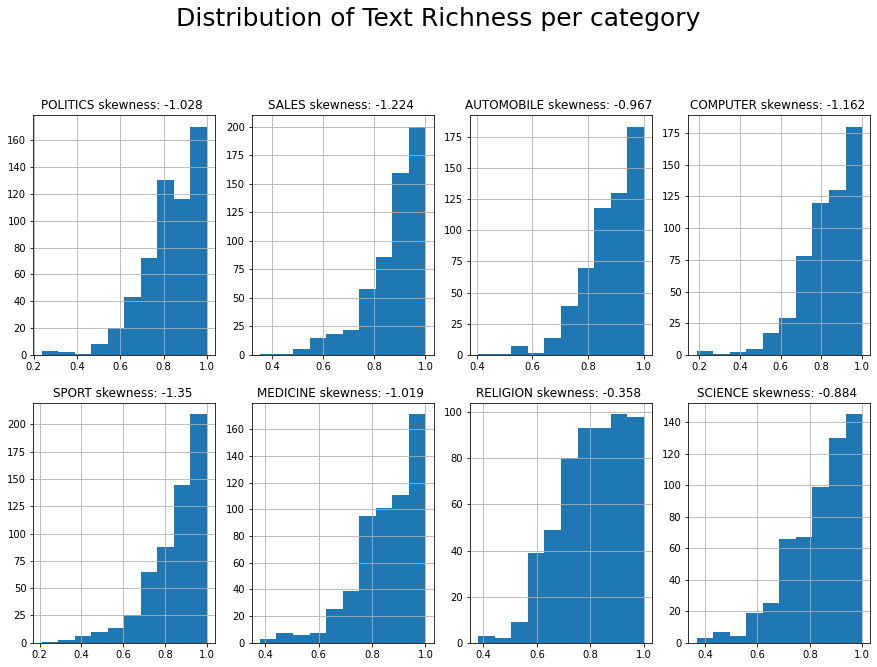

In [6]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Distribution of Text Richness per category',fontsize=25)
for n,i in enumerate( df_s['label'].unique() ):
    ax = fig.add_subplot(3,4,n+1)
    abs_freq = df_s.loc[ df_s['label'] == i,'richness_text'] 
    (abs_freq).hist(ax  = ax )
    values = df_s.loc[ df_s['label'] == i,'richness_text']
    ax.set_title(str.upper(i) + f' skewness: {round(stats.skew(values),3)  } ' )
#     ax.axis('off')

In [7]:
from itertools import chain
group_class_docs = df_s.groupby('label')['lemma_unique'].apply(list) 
group_class_uniqe_texts = group_class_docs.apply(lambda x : list(itertools.chain(*x)))

Text(0.5, 1.0, 'Lenght of Vocabolary for each category')

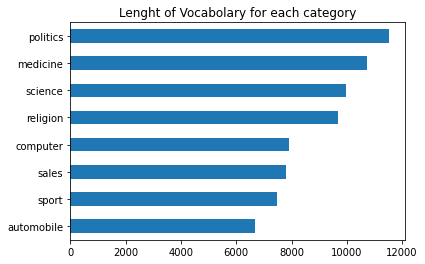

In [8]:
vocabolary_len_per_category = pd.Series({cat :len(group_class_uniqe_texts.apply(lambda x:list(set(x)))[cat]) for cat in df_s.label.unique() })
vocabolary_len_per_category.sort_values().plot(kind = 'barh').set_title('Lenght of Vocabolary for each category')

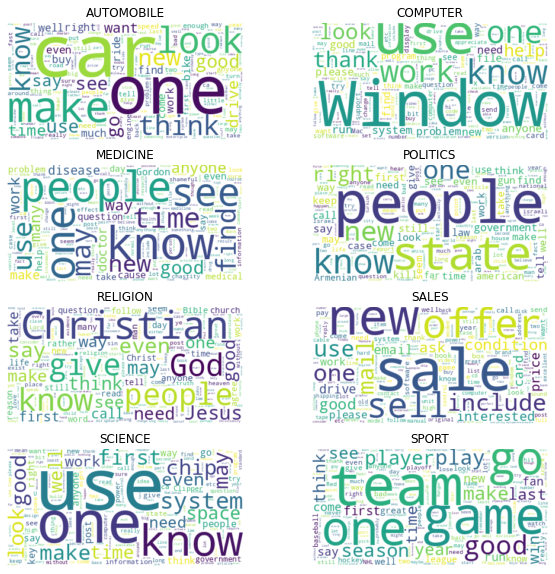

In [9]:
grouped_vocabolary = group_class_uniqe_texts.apply(lambda x:str(' '.join(x)))
vocabulary_len_category = dict({ k:len(word_freq(k).index.to_list()) for k in grouped_vocabolary.index.to_list() } )

fig = plt.figure(figsize=(10,10))
for n,i in enumerate(grouped_vocabolary.index.to_list()):
    ax = fig.add_subplot(4,2,n+1)
    wordcloud = WordCloud(max_words=3000,background_color="white").generate(str(grouped_vocabolary[i]))
    ax.set_title(str.upper(i) ) 
    ax.axis('off')
    ax.imshow(wordcloud,interpolation="bilinear")
plt.show()

# Preprocessing Pipeline 

As an optimization step, vectorization, i.e. the process of converting strings into numbers, was implemented. Then, target format was uniformed into integers.

In [10]:
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 8,dtype=int )

In [11]:
#++++++++++++++++++++++++++++ Preprocessing informative texts balances ++++++++++++++++++++++++++++++++++++
X = df_s['text']
y = df_s['target']
# Transform text
X_t = prep_pipeline.fit_transform(X)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Model Pipeline- Approach TF-IDF

BOW method is simple and works well, but the problem with that is that it treats all words equally. As a result, it cannot distinguish very common words or rare words. TF IDF helps us solving this issue, as a lower weight is assigned to those words that recurr very often to improve accuracy. In particular, unigrams are selected ad TF-IDF range.
TF-IDF provides us with a sparse matrix, that may result slow in computations: dense matrixes may be a good remedy. Moreover, scaling was performed.

Then, model creation step was implemented. We decided to use a sequential model for our classification purposes.
Selecting the best model, and so the best set of parameters, is crucial; a grid search exhaustively tests all combinations of a grid of parameters selected: we provided some values for neurons, epochs, batches and dropout.  GridSearchCV class computes accuracy on the basis of various combinations of parameters provided before, over a cross-validation procedure. 

## Hyperparameters-tuning  and CrossValidation

The following matrix contains the result of Cross Validation implementation. 
Of course, the combination of factor that gives us the best AUC (87.58%) is the first one with a standard batch size of 32,  50 epochs and 30 neurons.

In [34]:
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 neurons=20,
                 n_classes = 8 ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu')) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax')) # because we want the probability of each class as output , len 8 
    model.compile(loss='sparse_categorical_crossentropy', # sparse because it can accept the integer cat as y . len1 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)
param_grid = {
    'tfidf__max_features': [i*1000 for i in range(1,7)],
    'kc__epochs': [50],
    'kc__neurons': [30],
    'kc__batch_size':[32],
    'kc__dropout': [ 0.3, 0.1]
}

model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring=make_scorer(multiclass_roc_auc_score))
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#++++++++++++++++++++++++++++++ RUN GRID ++++++++++++++++++++++++++++++++++++
t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
display( results.head() ) 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Tuning Time s: 208.331


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,param_tfidf__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,5.797253,0.047511,0.365471,0.006451,32,0.3,50,30,6000,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.877900,0.869957,0.879712,0.875857,0.004236,1
11,6.254099,0.086771,0.373973,0.002553,32,0.1,50,30,6000,"{'kc__batch_size': 32, 'kc__dropout': 0.1, 'kc...",0.874487,0.871862,0.878937,0.875095,0.002920,2
4,5.521297,0.152293,0.339968,0.006968,32,0.3,50,30,5000,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.875241,0.868438,0.873254,0.872311,0.002856,3
10,5.646774,0.092774,0.353821,0.005776,32,0.1,50,30,5000,"{'kc__batch_size': 32, 'kc__dropout': 0.1, 'kc...",0.871075,0.867680,0.872112,0.870289,0.001893,4
2,4.828241,0.020186,0.299487,0.013422,32,0.3,50,30,3000,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.865397,0.865774,0.869456,0.866876,0.001831,5


In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#++++++++++++++++++++++++++++++ RUN GRID ++++++++++++++++++++++++++++++++++++
t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
display( results.head() ) 

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2021-11-29 19:34:52.767588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tuning Time s: 201.048


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,3.493981,0.028320,0.310026,0.008480,32,0.3,30,30,"(1, 1)","{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.777704,0.781022,0.776228,0.778318,0.002005,1
9,2.726360,0.013652,0.305853,0.006273,50,0.3,30,30,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.777040,0.772395,0.780212,0.776549,0.003210,2
0,3.579946,0.184372,0.323265,0.005089,32,0.3,30,20,"(1, 1)","{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.775050,0.772395,0.778884,0.775443,0.002664,3
8,2.691057,0.007501,0.303802,0.006724,50,0.3,30,20,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.782349,0.775050,0.765604,0.774334,0.006855,4
13,2.750768,0.029487,0.309666,0.012036,50,0.1,30,30,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.771732,0.769741,0.780876,0.774117,0.004849,5


In [14]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X_t,y)
time.time() - t0 

4.756308078765869

In [15]:
#save_keras_pipe(fitted_pipe,name_model = f'keras_model_{matrix_features}.h5', name_pipe =f'sklearn_pipeline_{matrix_features}.pkl' )
## Possible Error Dense Transformer Class pickle

# Model Pipeline- Approach Word Embedding

As we saw before, BOW and TF-IDF are two different ways to generate features for a text document, but they don't consider word similarity and co-occurences. Word Embedding is a kind of word representation that allows word with a similar meaning to have a similar representation with similarities detected mathematically.
In this case, we are able to reach a 81,64% accuracy by implementing a model with 50 batches, 30 neurons and  30 epochs.

In [16]:
import tensorflow_hub as hub
# load embeddings model from Tensorflow Hub
#https://stackoverflow.com/questions/62464152/universal-sentence-encoder-load-error-error-savedmodel-file-does-not-exist-at
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

matrix_features  = 512
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

n_classes =y.nunique()

In [17]:
class Embedding(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return embed(X).numpy()

emb_pipeline = Pipeline([
                    ('embed', Embedding()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])
#++++++++++++++++++++++++++++++ GRID ++++++++++++++++++++++++++++++++++++++
param_grid = {
    'kc__epochs': [30,50],
    'kc__neurons': [30, 100],
    'kc__batch_size':[32,50],
    'kc__dropout': [ 0.3, 0.1]
}

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=emb_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring='accuracy')

/Users/davide_lupis/Desktop/UniversityProjects/Uni_venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#++++++++++++++++++++++++++++++++++++ GRID Search +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
display( results.head() )

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuning Time s: 682.363


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,9.758351,0.247272,3.958082,0.659801,50,0.3,30,30,"{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.812210,0.823490,0.813413,0.816371,0.005058,1
0,10.112610,0.691168,3.499993,0.218053,32,0.3,30,30,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.814200,0.818182,0.810757,0.814380,0.003034,2
12,9.029199,0.393713,3.459528,0.247698,50,0.1,30,30,"{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.813537,0.816191,0.807437,0.812388,0.003665,3
10,9.687142,0.150057,3.507659,0.275009,50,0.3,50,30,"{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.808892,0.813537,0.812085,0.811505,0.001940,4
2,10.883349,0.083382,3.555959,0.259494,32,0.3,50,30,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.810219,0.806901,0.812749,0.809956,0.002395,5


In [19]:
#++++++++++++++++++++++++++++++++++++++++++++++ Fit the best model for embedding based on Grid +++++++++++++++++++++++++
emb_class = Embedding().fit(X_t)
keras_model_emb = create_model(features=512, neurons=30, n_classes=8, dropout=0.3).fit(emb_class.transform(X_t),
                                                                                       y,
                                                                                       batch_size = 30,
                                                                                       epochs = 50 ,
                                                                                       verbose= 0  )

# Testing 

As for the final part, we download from Sklearn api the test version of the dataset.
It is worth mentioning that the trained algorithm never saw the distributions of this data folder and the classes will be unbalanced to have a realistic idea of its performances.
To summarize the different procedures used:

* Pipeline 1  = [SpacyPreprocessing , TFIDF Vectorizer, Scaling , Classifier ]

The pros of the Pipeline 1 is that is explainable and effective.
The cons is that the dimensionality is quite high and the size of the vocabulary will affect the final result: we decided the best trade off for the TFIDF Vectorizer to be 3000.

* Pipeline 2  = [SpacyPreprocessing , Embedding, Classifier ]

The pros of the Pipeline 2 is that it reaches very efficient results with just 512 dimension, and the performances are quite similar if not better.
The cons is the complexity of the procedure in terms of mathematics involved.

Finally, we applied the final test and measured the results obtained using different metrics, but we took multiclass AUC as reference metric.

In [56]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)
from sklearn.metrics import roc_curve, auc
#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

### Load Models and Predict

Here we loaded our model to make some predictions, with our results summarized into the confusion matrix.

In [21]:
X_test_prep = prep_pipeline.transform(X_test)

 Multiclass Avg AUC : 0.852
              precision    recall  f1-score   support

  automobile       0.74      0.69      0.71       794
    politics       0.89      0.72      0.79      1955
     science       0.61      0.76      0.68       396
    computer       0.73      0.69      0.71      1050
    religion       0.68      0.80      0.74       649
       sales       0.52      0.84      0.64       390
       sport       0.71      0.59      0.64      1183
    medicine       0.68      0.87      0.76       796

    accuracy                           0.72      7213
   macro avg       0.69      0.74      0.71      7213
weighted avg       0.74      0.72      0.72      7213

Confusion matrix, without normalization


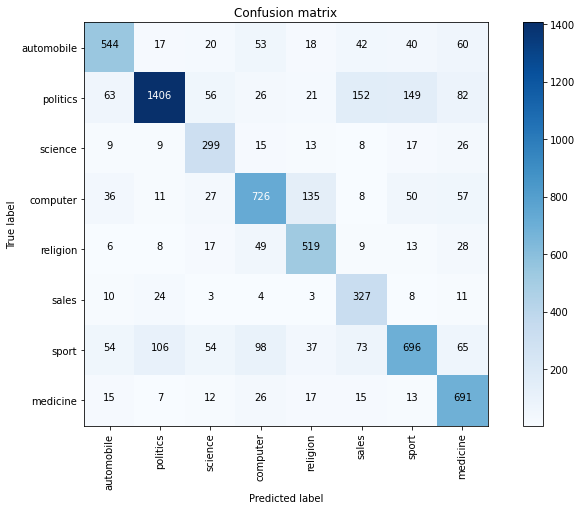

In [22]:
##Load the pipeline first:
#chosen_pipe = 'sklearn_pipeline.pkl'
#pipeline = joblib.load(chosen_pipe)
## Then, load the Keras model:

#chosen_model = 'keras_model.h5'
#pipeline.named_steps['kc'].model = load_model(chosen_model) 
pipeline = fitted_pipe
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#X_test_prep = prep_pipeline.transform(X_test)
y_pred  = pipeline.predict(X_test_prep)
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(10, 7, forward=True)
#fig.align_labels()

label_names = df['label'].unique()
print( f' Multiclass Avg AUC : { round( multiclass_roc_auc_score(y_test, y_pred, average="macro"),3 ) }' ) 
print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Confusion matrix')

 Multiclass Avg AUC : 0.876
              precision    recall  f1-score   support

  automobile       0.65      0.80      0.72       794
    politics       0.90      0.74      0.81      1955
     science       0.70      0.83      0.76       396
    computer       0.79      0.77      0.78      1050
    religion       0.78      0.81      0.80       649
       sales       0.54      0.80      0.64       390
       sport       0.71      0.64      0.67      1183
    medicine       0.88      0.88      0.88       796

    accuracy                           0.77      7213
   macro avg       0.74      0.79      0.76      7213
weighted avg       0.78      0.77      0.77      7213

Confusion matrix, without normalization


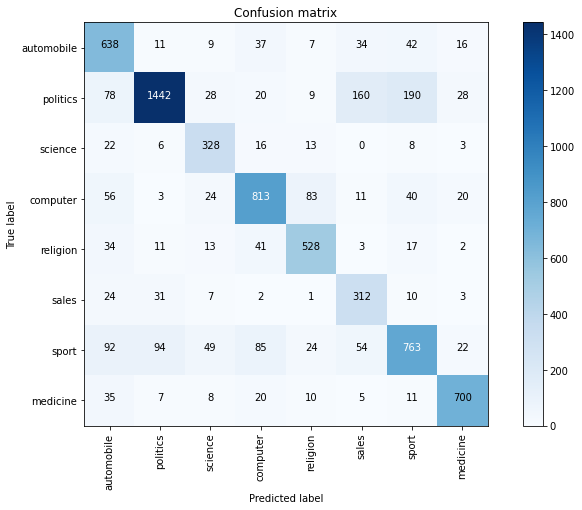

In [25]:
y_pred = np.argmax( keras_model_emb.model.predict( emb_class.transform(X_test_prep) )  , axis=-1 ) 

cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(10, 7, forward=True)
#fig.align_labels()
label_names = df['label'].unique()
print( f' Multiclass Avg AUC : { round( multiclass_roc_auc_score(y_test, y_pred, average="macro"),3 ) }' ) 
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
print(classification_report(y_test,y_pred, target_names=label_names)) 
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Confusion matrix')

In [ ]:
#chart , ranked_predictions = make_custom_predictions(fitted_pipe)

# Results and Discussion

In [57]:
#+++++++++++++++++++++++++++++++++++++ Balance Test to compare all 3 models ++++++++++++++++++++++++++++++++
df_tb = downsample(df)
# dependent and independent variable
X_test = df_tb['text']
y_test = df_tb['target']

X_test_prep = prep_pipeline.transform(X_test)

In [59]:
pipeline = fitted_pipe
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

bert_accuracy = 0.6753 # ____________________________Da modificare con Notebook BERT___________________________________
#X_test_prep = prep_pipeline.transform(X_test)
y_pred_pipe  = pipeline.predict(X_test_prep)
y_pred_emb = np.argmax( keras_model_emb.model.predict( emb_class.transform(X_test_prep) )  , axis=-1 ) 
comparison = pd.Series([ accuracy_score(y_test,y_pred_pipe),accuracy_score(y_test,y_pred_emb), bert_accuracy ] , index = ['TF-IDF','WordEmbedding','BERT'])
comparison

TF-IDF           0.738462
WordEmbedding    0.774038
BERT             0.675300
dtype: float64

To develop a multiclass classification problem, we started taking into account a huge collection of documents with a final goal of assigning each document to its main topic.
The Analytical approach consisted in three different pipelines.
* TF-IDF  
* UniversalSentence Encoder
* BERT

The final remarks:

* TF-IDF reached a 73 % accuracy and is the best trade trade off between complexity and performance
* Word-Embedding is the most performing, considering dimensional complexity and accuracy but it lacks of explainability.
* BERT is the newst approach to NLP and we do not fully understand the role of all the parameters involved.
We assume more computational power and preprocessing could increase the final results.

Our final conclusion is that the word embbeding is so far the best approach
